In [1]:
import pandas as pd
import pingouin as pg
import plotly.express as px 
import plotly.figure_factory as ff
import matplotlib.pyplot as plt


# Machine Learning
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay

##Otimização de Hiperpâmetros
import optuna

In [2]:
df_transacoes = pd.read_csv('./datasets/transacoes_fraude.csv')

### EDA

In [3]:
df_transacoes.head(10)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0
5,cliente62C357,Débito,4848.49,7354.41,2505.92,2025-07-08T19:16:37.207970,0
6,cliente320C76,Crédito,1600.44,7296.87,5696.43,2024-09-07T02:23:16.975044,0
7,cliente32CB58,Crédito,1296.71,10562.92,9266.21,2023-08-28T23:09:19.817457,0
8,cliente67AFD9,Débito,1187.35,10935.18,9747.83,2024-05-21T09:01:08.163132,0
9,cliente84F77D,PIX,3271.51,3405.61,134.10,2022-09-26T10:33:12.415982,0


In [4]:
df_transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cliente                     13000 non-null  object 
 1   Tipo de Transacao           13000 non-null  object 
 2   Valor da Transacao          13000 non-null  float64
 3   Valor Anterior a Transacao  13000 non-null  float64
 4   Valor Apos a Transacao      13000 non-null  float64
 5   Horario da Transacao        13000 non-null  object 
 6   Classe                      13000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 711.1+ KB


In [5]:
df_transacoes['Horario da Transacao'] = pd.to_datetime(df_transacoes['Horario da Transacao'])


In [6]:
df_transacoes['Tipo de Transacao'].unique()

array(['Saque', 'PIX', 'Débito', 'Crédito'], dtype=object)

In [7]:
contagem_target = df_transacoes.value_counts('Classe')
contagem_target

Classe
0    11570
1     1430
Name: count, dtype: int64

In [8]:
px.bar(contagem_target, color=contagem_target.index)

In [9]:
percentual_target = contagem_target / len(df_transacoes) * 100
px.bar(percentual_target, color=percentual_target.index, )

In [10]:
percentual_tipo_transasao = df_transacoes.value_counts('Tipo de Transacao') / len(df_transacoes) * 100
px.bar(percentual_tipo_transasao, color=percentual_tipo_transasao.index)

In [11]:
lista = ['Saque', 'PIX', 'Débito', 'Crédito']

In [12]:
crosstab_tipo_transasao = pd.crosstab(df_transacoes['Classe'], df_transacoes['Tipo de Transacao'], margins=True).reset_index()

tabela_tipo_transasao = ff.create_table(crosstab_tipo_transasao)

tabela_tipo_transasao.show()

In [13]:
valor_esperado, valor_observado, estatisticas = pg.chi2_independence(df_transacoes, 'Classe', 'Tipo de Transacao')

In [14]:
valor_esperado

Tipo de Transacao,Crédito,Débito,PIX,Saque
Classe,,,,
0,2840.88,2928.1,2913.86,2887.16
1,351.12,361.9,360.14,356.84


In [15]:
valor_observado

Tipo de Transacao,Crédito,Débito,PIX,Saque
Classe,,,,
0,2875,2917,2878,2900
1,317,373,396,344


In [16]:
estatisticas.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,8.63903,3.0,0.03450,0.02578,0.69148
1,cressie-read,0.66667,8.63857,3.0,0.03450,0.02578,0.69146
2,log-likelihood,0.00000,8.64140,3.0,0.03446,0.02578,0.69162
3,freeman-tukey,-0.50000,8.64683,3.0,0.03437,0.02579,0.69192
4,mod-log-likelihood,-1.00000,8.65510,3.0,0.03425,0.02580,0.69238
5,neyman,-2.00000,8.68021,3.0,0.03386,0.02584,0.69379


As variáveis Tipo de Transacao e Classe não são independentes. Qui-Quadrado (p-value = 0.034)
As variáveis Valor da Transacao e Classe são independentes. Qui-Quadrado (p-value = 0.545)
As variáveis Valor Anterior a Transacao e Classe são independentes. Qui-Quadrado (p-value = 0.491)
As variáveis Horario da Transacao e Classe são independentes. Qui-Quadrado (p-value = 0.495)

### Treinamento do Modelo

In [17]:
df_transacoes.drop(columns=['Cliente'], axis=1, inplace=True)

In [18]:
X = df_transacoes.drop(columns=['Classe'])
y = df_transacoes['Classe']

In [21]:
categorical_features = ['Tipo de Transacao']

categorical_tranformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_tranformer, categorical_features)
    ]
)

dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier())])

### Validação Cruzada

In [22]:
cv_foldds = StratifiedKFold(n_splits=3, shuffle=True, random_state=51)
metrics_result = cross_validate(dt_model, X, y, cv=cv_foldds, scoring=['accuracy'],
return_estimator = True)

In [23]:
metrics_result

{'fit_time': array([0.02060509, 0.0103941 , 0.00997138]),
 'score_time': array([0.00786018, 0.00579095, 0.00610256]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['Tipo de Transacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImp

In [24]:
metrics_result['test_accuracy'].mean()

np.float64(0.8900000046150297)

### Métricas


In [25]:
y_pred = cross_val_predict(dt_model, X, y, cv=cv_foldds)

In [26]:
classification_report_str = classification_report(y, y_pred)

print(f'Relatório de classificação:\n{classification_report_str}')

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     11570
           1       0.00      0.00      0.00      1430

    accuracy                           0.89     13000
   macro avg       0.45      0.50      0.47     13000
weighted avg       0.79      0.89      0.84     13000



c:\Users\julia\.virtualenvs\DesafioArvoredeDecisao-a8cD0E9T\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\julia\.virtualenvs\DesafioArvoredeDecisao-a8cD0E9T\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\julia\.virtualenvs\DesafioArvoredeDecisao-a8cD0E9T\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



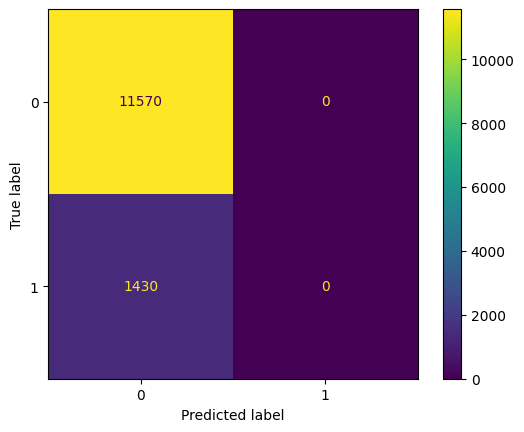

In [45]:
confusion_matrix_modelo = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix_modelo)
disp.plot()

### Tuning de Hiperparâmetros

In [33]:
def decisiontree_optuna(trial):

    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_depth = trial.suggest_int('max_depth', 2, 8)

    dt_model.set_params(classifier__min_samples_leaf = min_samples_leaf)
    dt_model.set_params(classifier__max_depth= max_depth)

    scores = cross_val_score(dt_model, X, y, cv=cv_foldds, scoring='accuracy')

    return scores.mean()

In [34]:
estudo_decisiontree = optuna.create_study(direction='maximize')
estudo_decisiontree.optimize(decisiontree_optuna, n_trials=200)

[I 2025-06-04 18:11:17,432] A new study created in memory with name: no-name-3e1bdba6-2195-4705-84d8-a49201637cd4
[I 2025-06-04 18:11:17,496] Trial 0 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 4, 'max_depth': 5}. Best is trial 0 with value: 0.8900000046150297.
[I 2025-06-04 18:11:17,553] Trial 1 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 11, 'max_depth': 3}. Best is trial 0 with value: 0.8900000046150297.
[I 2025-06-04 18:11:17,611] Trial 2 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 16, 'max_depth': 7}. Best is trial 0 with value: 0.8900000046150297.
[I 2025-06-04 18:11:17,668] Trial 3 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 6, 'max_depth': 3}. Best is trial 0 with value: 0.8900000046150297.
[I 2025-06-04 18:11:17,726] Trial 4 finished with value: 0.8900000046150297 and parameters: {'min_samples_leaf': 6, 'max_depth': 7}. Best is trial 0 with value:

In [35]:
print(f'Melhor acurácia: {estudo_decisiontree.best_value}')
print(f'Melhores parâmetros: {estudo_decisiontree.best_params}')

Melhor acurácia: 0.8900000046150297
Melhores parâmetros: {'min_samples_leaf': 4, 'max_depth': 5}


### Visualizar Árvore

In [36]:
X_train_tree = X.copy()
X_train_tree['Tipo de Transacao_label'] = X_train_tree['Tipo de Transacao'].astype('category').cat.codes
X_train_tree.drop(columns=['Tipo de Transacao'], axis=1, inplace=True)
X_train_tree.rename(columns={'Tipo de Transacao_label' : 'Tipo de Transacao'}, inplace=True)
X_train_tree.head(10)

,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Tipo de Transacao
0,390.39,5446.75,5056.36,2023-03-14 07:29:28.256579,3
1,3272.03,12167.89,8895.86,2023-02-12 17:54:09.119410,3
2,4905.72,8217.63,3311.91,2023-10-03 17:31:42.087599,2
3,3073.23,7833.16,4759.93,2024-05-23 17:57:02.055680,2
4,4233.03,6920.82,2687.79,2022-10-07 17:30:36.879557,2
5,4848.49,7354.41,2505.92,2025-07-08 19:16:37.207970,1
6,1600.44,7296.87,5696.43,2024-09-07 02:23:16.975044,0
7,1296.71,10562.92,9266.21,2023-08-28 23:09:19.817457,0
8,1187.35,10935.18,9747.83,2024-05-21 09:01:08.163132,1
9,3271.51,3405.61,134.10,2022-09-26 10:33:12.415982,2


In [39]:
X_train_tree = X_train_tree.select_dtypes(exclude=['datetime64[ns]', 'datetime64'])


In [40]:
clf_decisiontree = DecisionTreeClassifier(min_samples_leaf=estudo_decisiontree.best_params['min_samples_leaf'], max_depth=estudo_decisiontree.best_params['max_depth'])

y_train_tree = y.copy()

clf_decisiontree.fit(X_train_tree, y_train_tree)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4)

[Text(0.5461956521739131, 0.9166666666666666, 'Valor da Transacao <= 695.755\ngini = 0.196\nsamples = 13000\nvalue = [11570, 1430]'),
 Text(0.31521739130434784, 0.75, 'Valor Apos a Transacao <= 3150.01\ngini = 0.163\nsamples = 1757\nvalue = [1600, 157]'),
 Text(0.4307065217391305, 0.8333333333333333, 'True  '),
 Text(0.17391304347826086, 0.5833333333333334, 'Valor Anterior a Transacao <= 2523.845\ngini = 0.209\nsamples = 523\nvalue = [461, 62]'),
 Text(0.08695652173913043, 0.4166666666666667, 'Valor da Transacao <= 517.155\ngini = 0.17\nsamples = 362\nvalue = [328, 34]'),
 Text(0.043478260869565216, 0.25, 'Valor Apos a Transacao <= 52.3\ngini = 0.199\nsamples = 285\nvalue = [253, 32]'),
 Text(0.021739130434782608, 0.08333333333333333, 'gini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(0.06521739130434782, 0.08333333333333333, 'gini = 0.192\nsamples = 279\nvalue = [249, 30]'),
 Text(0.13043478260869565, 0.25, 'Valor Apos a Transacao <= 1114.63\ngini = 0.051\nsamples = 77\nvalue = [75, 

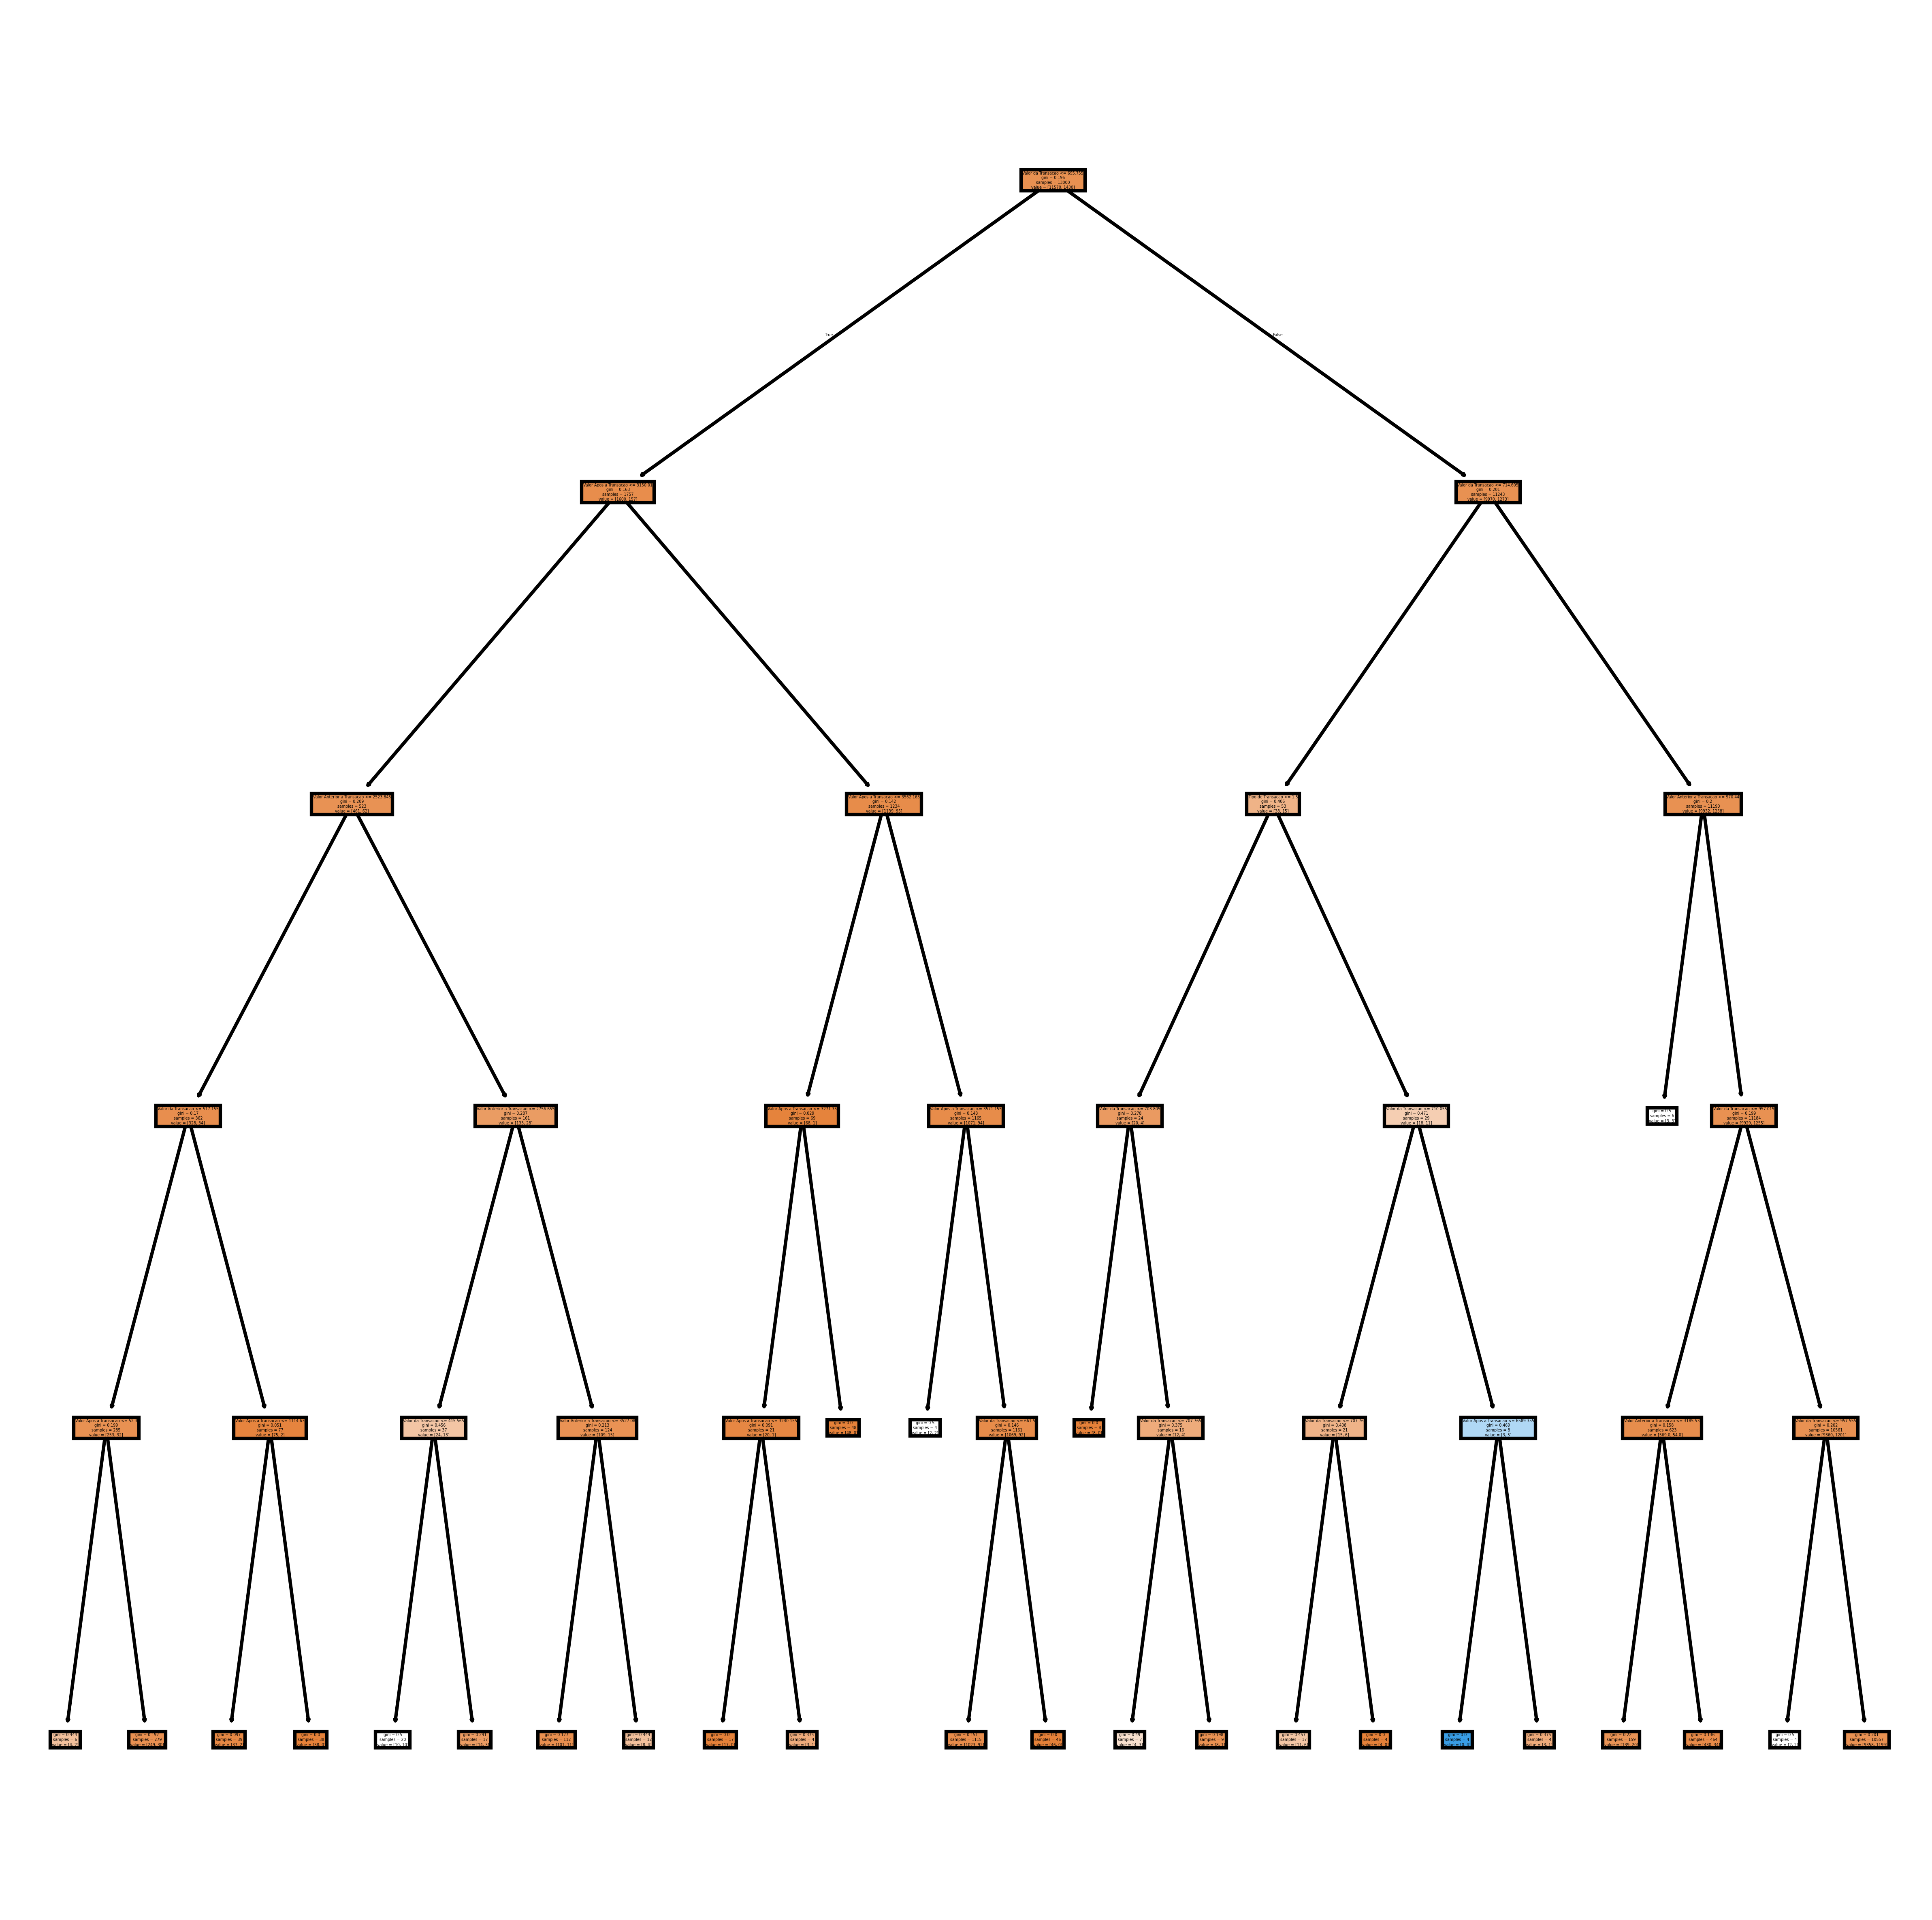

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=600)

plot_tree(clf_decisiontree,
          feature_names=X_train_tree.columns.to_numpy(),
          filled=True)

O modelo de árvore de decisão conseguiu detectar 1 % de não fraude (Recall = 1.00), o que não é muito positivo. E ele apresentou 0 % de falsos positivos, impactando a experiência de clientes legítimos. Isso mostra que a árvore de decisão não é uma melhor escolha